In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [2]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)



PartI : Read in the dataset. Check what the shape of dataset and what data contains.
Separate the train and test dataset. 

In [3]:
#read train data
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
trainX, train_Y = train_input[1:, :21], train_input[1:,-1].astype(int)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))
trainY = train_Y-1

In [4]:
print(trainX[:1])
print(trainX.shape)

[[0.25925926 0.         0.         0.         0.         0.
  0.         0.81333333 0.04411765 0.47252747 0.04733728 0.34463277
  0.11009174 0.03448276 0.11111111 0.         0.47244094 0.58715596
  0.40366972 0.27137546 1.        ]]
(2126, 21)


In [5]:
print(trainY[:10])
print(trainY.shape)

[1 0 0 0 0 2 2 2 2 2]
(2126,)


In [6]:
# divide the dataset in 70:30 ratio for training and testing
X_train = trainX[:1488]
y_train = trainY[:1488]
X_test = trainX[-638:]
y_test = trainY[-638:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1488, 21)
(1488,)
(638, 21)
(638,)


PartII: Design the neural network
Design a feedforward neural network which consists of an input layer, 
one hidden layer of 10 neurons with ReLU activation function, 
and an output softmax layer. 
Assume a learning rate 𝛼 = 0.01, 
L2 regularization with weight decay parameter 𝛽 = 10−6, 
and batch size = 32. 
Use appropriate scaling of input features.

In [7]:
NUM_CLASSES = 3
epochs = 100
batch_size = 32
num_neurons = 10
seed = 10

In [8]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
# model = keras.Sequential([
#     keras.layers.Dense(num_neurons, activation='relu'),
#     keras.layers.Dense(NUM_CLASSES)
# ])
def build_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=21, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(3,activation='softmax'))
    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.01,
                                       beta_1=0.9,
                                       beta_2=0.999,
                                       epsilon=1e-07,
                                       amsgrad=False)
    model.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [10]:
#complie the model use K-th folder validation
k = 5
num_val_samples = len(trainX)//k
all_scores = []
histories_acc = []
histories_loss = []

In [11]:
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
        

In [12]:
for i in range(k):
    print('processing fold #', i)
    # prepare validation data: the data from k-th set
    validation_data = trainX[i * num_val_samples: (i+1)*num_val_samples]
    validation_targets = trainY[i * num_val_samples: (i+1)*num_val_samples]
    
    # prepare training data: all the data except k-th set
    partial_train_data = np.concatenate(
        [trainX[:i * num_val_samples],
         trainX[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_target = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    # create the model
    model = build_model()
    
    # train the model 
    history = model.fit(partial_train_data, partial_train_target,
                                        epochs=epochs,
                                        verbose = 2,
                                        batch_size=batch_size,
                        callbacks=[TestCallback((X_test, y_test))])
    
    acc_history = history.history['accuracy']
    histories_acc.append(acc_history)
    
    loss_history = history.history['loss']
    histories_loss.append(loss_history)
    
    # evaluate the model on validation_data
    score = model.evaluate(validation_data, validation_targets, verbose=2)
    all_scores.append(score) # should have 5 histories

processing fold # 0
Epoch 1/100

Testing loss: 0.7446687817573547, acc: 0.8338558077812195

54/54 - 0s - loss: 0.8280 - accuracy: 0.8136
Epoch 2/100

Testing loss: 0.7235260605812073, acc: 0.8338558077812195

54/54 - 0s - loss: 0.7373 - accuracy: 0.8289
Epoch 3/100

Testing loss: 0.7188014388084412, acc: 0.8338558077812195

54/54 - 0s - loss: 0.7257 - accuracy: 0.8289
Epoch 4/100

Testing loss: 0.7178393602371216, acc: 0.8338558077812195

54/54 - 0s - loss: 0.7231 - accuracy: 0.8289
Epoch 5/100

Testing loss: 0.7176607251167297, acc: 0.8338558077812195

54/54 - 0s - loss: 0.7227 - accuracy: 0.8289
Epoch 6/100

Testing loss: 0.7176218628883362, acc: 0.8338558077812195

54/54 - 0s - loss: 0.7226 - accuracy: 0.8289
Epoch 7/100

Testing loss: 0.7176092267036438, acc: 0.8338558077812195

54/54 - 0s - loss: 0.7225 - accuracy: 0.8289
Epoch 8/100

Testing loss: 0.7176030874252319, acc: 0.8338558077812195

54/54 - 0s - loss: 0.7225 - accuracy: 0.8289
Epoch 9/100

Testing loss: 0.717599570751190

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [14]:
print(all_scores) # validation loss; validation accuracy for each 5 folders

[[0.9749742746353149, 0.5764706134796143], [0.8949742913246155, 0.6564705967903137], [0.5726224184036255, 0.9788235425949097], [0.6663742065429688, 0.9011764526367188], [0.7537978887557983, 0.7976470589637756]]


In [15]:
average_acc_history = [
    np.mean([x[i] for x in histories_acc]) for i in range(epochs)]

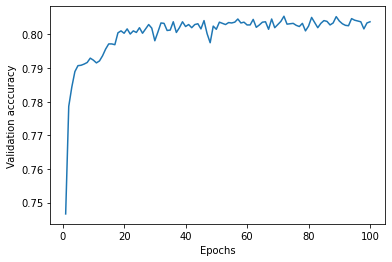

In [16]:
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acccuracy')
plt.savefig('result.png')


In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 530us/step - loss: 0.7176 - accuracy: 0.8339


In [18]:
test_loss

0.7175891399383545

In [19]:
test_acc

0.8338558077812195